# Welcome to the GEP Generator

This Jupyter based interface has been designed to support scenario runs for the Global Electrification Platform. 

The interface is built upon a modified version of [OnSSET](http://www.onsset.org/) developed by KTH dESA to provide an easy and quick way to generate electrification investment scenarios compatible with GEP data guidelines and protocols. 

Follow the steps below to generate custom electrification investment outlooks for your country of interest.

#### Start by importing the code 

In [1]:
from onsset import *
from IPython.display import display, Markdown, HTML
%matplotlib inline

2023-04-24 11:44:55,680		CACHEDIR=C:\Users\alexl\.matplotlib
2023-04-24 11:44:55,697		Using fontManager instance from C:\Users\alexl\.matplotlib\fontlist-v310.json
2023-04-24 11:44:56,158		Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2023-04-24 11:44:56,163		Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2023-04-24 11:44:56,165		Loaded backend module://ipykernel.pylab.backend_inline version unknown.


**Note**: In case you encounter an error please refer to the import section of the onsset.py code.

# 1. GIS data selection

First, run the cell below to browse to the directory your input CSV file is located at and select the input file. Sample file shall be located at .\ gep-onsset\test_data. 


In [2]:
import tkinter as tk
from tkinter import filedialog, messagebox
from openpyxl import load_workbook
root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)
messagebox.showinfo('OnSSET', 'Open the input file with extracted GIS data')
input_file = filedialog.askopenfilename()

onsseter = SettlementProcessor(input_file)

In [3]:
pv_path = os.path.abspath(os.path.join(r'.\Input', 'sl-2-pv.csv'))
wind_path = os.path.abspath(os.path.join(r'.\Input', 'sl-2-wind.csv'))

# 2. Modelling period and target electrification rate

Next, define the modelling period and the electrification rate to be achieved by the end of the analysis, and also for an intermediate year. Further down you will also define an intermediate year and target (in the ***Levers*** section).

*On the GEP Explorer, the end year electrification rate target is set to 100%, and the intermediate target is set to follow a linear increase from the current level. If a country for example has 52% access by 2020, the target would be to increase electrification rate by ~4% per year to reach 100% by 2030. Therefore the intermediate target would be 80% by 2025.*

In [4]:
start_year = 2020
end_year = 2030
electrification_rate_target = 1 # E.g. 1 for 100% electrification rate or 0.80 for 80% electrification rate 

intermediate_year = 2025
intermediate_electrification_target = 0.75 # E.g. for a target electrification rate of 75%, enter 0.75

yearsofanalysis = [intermediate_year, end_year]
eleclimits = {intermediate_year: intermediate_electrification_target, end_year: electrification_rate_target}
time_steps = {intermediate_year: intermediate_year-start_year, end_year: end_year-intermediate_year}

# 3. Levers

Next, define the values of the levers. These are the 6 levers that are available on the GEP Explorer. Contrary to the GEP Explorer where each lever has two or three pre-defined values, here they can take any value.

#### Lever 1: Population growth

For the first lever first, enter the expected population in the country by the end year of the analysis (e.g. 2030). 

*The default values in the GEP Explorer are based on the medium growth variant and high growth variant of the UN Population Database, found <a href="https://population.un.org/wpp/" target="_blank">here</a>.*

In [5]:
end_year_pop = 9686665

#### Lever 2: Electricity demand target
For the second lever, enter the target tier (level of electricity access) for urban and rural households respectively. This can take a value between "1" (lowest level of electricity access) and "5" (highest level of electricity access) as in ESMAPs Multi-Tier Framework for Measuring Electricity Access (found <a href="https://www.esmap.org/node/55526" target="_blank">here</a>). Alternatively, enter "6" to use a distribution of the tiers across the country based on poverty levels and GDP according to the methodology found <a href="https://www.mdpi.com/1996-1073/12/7/1395" target="_blank">here</a>.   

*On the GEP Explorer, the following three electricity demand targets are used:*

*Top down demand target - Low: In this case, all urban clusters are tergeted to reach the current average consumption level of electrified households, and rural settlements are assigned Tier 1.* 

*Top down demand target - High: In this case, all urban clusters are tergeted to reach one Tier higher than the current average consumption level of electrified households, and rural settlements are assigned Tier 3.*

*Bottom up demand target (Poverty - GDP): In this case each settlement is assigned a demand target based on poverty and GDP levels as described in the methodology above. Choose "6" for both the urban_target_tier and rural_target_tier to use this option* 

In [6]:
urban_target_tier = 4
rural_target_tier = 2

#### Lever 3: Intermediate investment plan
For the third lever, restrictions can be placed on how many grid connections can be achieved in a year.

*On the GEP Explorer there are two options that explore how to achieve the intermediate electrification target. Not capped scenario assumes that the electrification rate increases linearly over the modelling years; no restrictions are set in terms of feasible grid connections per year. Capped growth scenario assumes that the electrification rate increases as in the first scenario but is subject to grid connections limitation, equal to 2.5% of population per year. Note that on the platfrom, there are no restrictions applied after 2025, thus the restriction for 2030 is always set to "999999999"*

In [7]:
# This is the maximum amount of new households that can be connected to the grid in one year (thousands)
annual_new_grid_connections_limit_intermediate = 999999999 # Limit per year from start year (e.g. 2018) to intermediate year (e.g. 2025)
annual_new_grid_connections_limit_end = 999999999 # Limit per year from intermediate year (e.g. 2025) to end year (e.g. 2030)

#### Lever 4: Grid generating cost of electricity
This lever examines different average costs of generating electricity by the power-plants connected to the national grid. This cost is one of the factors that affect the LCoE of connecting to the grid (together with extension of the grid lines etc.), and may affect the split between grid- and off-grid technologies.

*On the GEP Explorer, the Estimated on-grid cost is based on either national plans or a power optimization model. The High-on grid cost is assumed to be 25% higher*

In [8]:
grid_generation_cost = 0.047 ### This is the grid cost electricity USD/kWh as expected in the end year of the analysis

#### Lever 5: PV system cost adjustment
This lever reflects the role of PV system costs on electrification results. All PV based systems will be adjusted by a factor to simulate a higher or lower cost of PV systems (compared to the baseline values entered below). A value lower than 1 means lower investment costs for PV systems compared to baseline projection, and a value larger than 1 means higher investment cost for PV systems compared to baseline. E.g. "0.75" would mean a cost that is 25% lower compared to baseline costs.

*On the GEP Explorer, three values for this parameter are explored:*

*Expected PV cost: Adjustment factor set to 1*

*High PV cost: Adjustment factor set to 1.25 to simulate 25% higher costs*

*Low PV cost: Adjustment factor set to 0.75 to simulate 25% lower cost*

In [9]:
pv_adjustment_factor = 1

#### Lever 6: Rollout plan
This lever reflects the electrification approach to be examined. On the GEP Explorer, there are currently two options in use:

**Nationwide Least Cost approach:** This options aims to achieve the electrification rate targets set for the intermediate and end year. For the years where the target is set below 100%, the algorithm prioritizes grid densification first (ramp up in already electrified clusters) then selection based on lowest invetsment cost per capita to choose which clusters to be electrified. Note! a generation capacity limit for the centralized grid is applied in order to keep grid expansion to sensible levels until the intermediate year. On the GEP Explorer, this follows historical trends for the countries in the region that managed the largest relative increase in recent years.*

**Forced grid approach:** This can take the following forms.

- Forced grid under a defined buffer zone (auto_intensification set equal to Xkm) & least cost approach outside of the buffer zone.

- Forced grid under a defined buffer zone (auto_intensification set equal to Xkm) & no electrification outside the buffer zone.

In [10]:
prioritization = 6                        # Select 5, 4 or 6; 5 = Nationwide Least Cost approach, 4 = Forced grid connection within a buffer only, 6 = Forced grid within buffer + least cost out of the buffer

auto_intensification = 2                  # Buffer distance (km) for automatic intensification if choosing prioritization 4 or 6

# This is the maximum generation capacity that can be added to the grid in one year (MW)
annual_grid_cap_gen_limit_intermediate = 54 # Limit per year from start year (e.g. 2018) to intermediate year (e.g. 2025)
annual_grid_cap_gen_limit_end = 999999999 # Limit per year from intermediate year (e.g. 2025) to end year (e.g. 2030)

# 4. Enter country specific data

In addition to the levers above the user can customize a large number of variables describing the social - economic - technological environment in the selected country. 

**Note!** Most input values shall represent future estimates for the variable, i.e. they describe and **NOT** current values.

### a. Demographics and Social components

In [11]:
pop_start_year = 7946439       ### Write the population in the base year (e.g. 2020) 

urban_ratio_start_year = 0.421 ### Write the urban population population ratio in the base year (e.g. 2020)
urban_ratio_end_year = 0.5     ### Write the urban population population ratio in the end year (e.g. 2030)

num_people_per_hh_urban = 4.4     ### Write the number of people per household expected in the end year (e.g. 2030)
num_people_per_hh_rural = 5.2   ### Write the number of people per household expected in the end year (e.g. 2030)

elec_ratio_start_year = 0.23   ### Write the electrification rate in the base year (e.g. 2020)
urban_elec_ratio = 0.49       ### Write urban electrification rate in the base year (e.g. 2020)
rural_elec_ratio = 0.05         ### Write rural electrification rate in the base year (e.g. 2020)

### b. Technology specifications & costs

The cell below contains all the information that is used to calculate the levelized costs for all the technologies, including grid. These default values should be updated to reflect the most accurate values in the country. There are currently 7 potential technologies to include in the model:
* Grid
* PV Mini-grid
* Wind Mini-grid
* Hydro Mini-grid
* Diesel Mini-grid
* PV Stand-alone systems
* Diesel Stand-alone systems

First, decide whether to include diesel technologies or not:

In [12]:
diesel_techs = 0                        ### 0 = diesel NOT included, 1 = diesel included 

In [13]:
grid_power_plants_capital_cost = 1363   ### The cost in USD/kW is for capacity upgrades of the grid
grid_losses = 0.167                     ### The fraction of electricity lost in transmission and distribution (percentage)  

In [14]:
diesel_price = 0.5                     ### This is the diesel price in USD/liter as expected in the end year of the analysis

sa_diesel_cost = {'diesel_price': diesel_price,
                  'efficiency': 0.28,
                  'diesel_truck_consumption': 14,
                  'diesel_truck_volume': 300}

mg_diesel_cost = {'diesel_price': diesel_price,
                  'efficiency': 0.33,
                  'diesel_truck_consumption': 14,
                  'diesel_truck_volume': 300}

In [15]:
sa_diesel_capital_cost = {float("inf"): 938}      ### Stand-alone Diesel capital cost (USD/kW) as expected in the years of the analysis
mg_diesel_capital_cost = {float("inf"): 721}      ### Mini-grid Diesel capital cost (USD/kW) as expected in the years of the analysis
mg_pv_capital_cost = {float("inf"): 2950}         ### Mini-grid PV capital cost (USD/kW) as expected in the years of the analysis
mg_wind_capital_cost = {float("inf"): 3750}       ### Mini-grid Wind capital cost (USD/kW) as expected in the years of the analysis
mg_hydro_capital_cost = {float("inf"): 3000}      ### Mini-grid Hydro capital cost (USD/kW) as expected in the years of the analysis

In [16]:
sa_pv_capital_cost_1 = 9620          ### Stand-alone PV capital cost (USD/kW) for household systems under 20 W
sa_pv_capital_cost_2 = 8780          ### Stand-alone PV capital cost (USD/kW) for household systems between 21-50 W
sa_pv_capital_cost_3 = 6380           ### Stand-alone PV capital cost (USD/kW) for household systems between 51-100 W
sa_pv_capital_cost_4 = 4470           ### Stand-alone PV capital cost (USD/kW) for household systems between 101-1000 W
sa_pv_capital_cost_5 = 6950           ### Stand-alone PV capital cost (USD/kW) for household systems over 1 kW

The cells below contain additional technology specifications

In [17]:
discount_rate = 0.08 # E.g. 0.08 means a discount rate of 8%
existing_grid_cost_ratio = 0.1        ### The additional cost per round of electrification (percentage) 

# Transmission and distribution costs
hv_line_capacity=69 # kV
hv_line_cost=53000 # USD/km
mv_line_cost = 7000 # USD/kW
mv_line_capacity=33 # kV
mv_line_max_length=50 # km
mv_increase_rate=0.1
max_mv_line_dist = 50 # km
MV_line_amperage_limit = 8  # Ampere (A)
lv_line_capacity=0.24 #kV
lv_line_max_length=0.5 # km
lv_line_cost=4250 # USD/km
service_Transf_type=50  # kVa
service_Transf_cost=4250  # $/unit
max_nodes_per_serv_trans=300  # maximum number of nodes served by each service transformer
hv_lv_transformer_cost=25000 # USD/unit
hv_mv_transformer_cost=25000 # USD/unit
mv_lv_transformer_cost=10000 # USD/unit
mv_mv_transformer_cost=10000 # USD/unit


# Centralized grid costs
grid_calc = Technology(om_of_td_lines=0.02,
                        distribution_losses=grid_losses,
                        connection_cost_per_hh=125,
                        base_to_peak_load_ratio=0.8,
                        capacity_factor=1,
                        tech_life=30,
                        grid_penalty_ratio=1,
                        grid_capacity_investment=grid_power_plants_capital_cost,
                        grid_price=grid_generation_cost)

mg_pv_hybrid_calc = Technology(om_of_td_lines=0.02,
                               distribution_losses=0.05,
                               connection_cost_per_hh=100,
                               capacity_factor=0.5,
                               tech_life=20,
                               mini_grid=True,
                               hybrid=True)

mg_wind_hybrid_calc = Technology(om_of_td_lines=0.02,
                                 distribution_losses=0.05,
                                 connection_cost_per_hh=100,
                                 capacity_factor=0.5,
                                 tech_life=20,
                                 mini_grid=True,
                                 hybrid=True)

# Mini-grid hydro costs
mg_hydro_calc = Technology(om_of_td_lines=0.02,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capacity_factor=0.5,
                            tech_life=30,
                            capital_cost=mg_hydro_capital_cost,
                            om_costs=0.02,
                            )

# Mini-grid wind costs
mg_wind_calc = Technology(om_of_td_lines=0.02,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capital_cost=mg_wind_capital_cost,
                            om_costs=0.02,
                            tech_life=20,
                            )

# Mini-grid PV costs
mg_pv_calc = Technology(om_of_td_lines=0.02,
                        distribution_losses=0.05,
                        connection_cost_per_hh=100,
                        base_to_peak_load_ratio=0.85,
                        tech_life=20,
                        om_costs=0.015,
                        capital_cost= mg_pv_capital_cost                        
                       )

# Stand-alone PV costs
sa_pv_calc = Technology(base_to_peak_load_ratio=0.9,
                        tech_life=15,
                        om_costs=0.02,
                        capital_cost={0.020: sa_pv_capital_cost_1 * pv_adjustment_factor, 
                                      0.050: sa_pv_capital_cost_2 * pv_adjustment_factor, 
                                      0.100: sa_pv_capital_cost_3 * pv_adjustment_factor, 
                                      1: sa_pv_capital_cost_4 * pv_adjustment_factor, 
                                      5: sa_pv_capital_cost_5 * pv_adjustment_factor},
                        standalone=True
                        )

# Mini-grid diesel costs
mg_diesel_calc = Technology(om_of_td_lines=0.03,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capacity_factor=0.7,
                            tech_life=15,
                            om_costs=0.1,
                            efficiency=0.33,
                            capital_cost=mg_diesel_capital_cost,
                            diesel_price=diesel_price,
                            diesel_truck_consumption=33.7,
                            diesel_truck_volume=15000,
                            )

# Stand-alone diesel costs
sa_diesel_calc = Technology(base_to_peak_load_ratio=0.9,
                            capacity_factor=0.7,
                            tech_life=10,
                            om_costs=0.1,
                            capital_cost=sa_diesel_capital_cost,
                            diesel_price=diesel_price,
                            standalone=True,
                            efficiency=0.28,
                            diesel_truck_consumption=14,
                            diesel_truck_volume=300)

# 5. Calibration of start year values and general information

The following steps calibrate the start year conditions in the country in terms of population and current electrification rate, and also adds some additional useful information to be used in the further calculations. If you have retrieved the input file from Energydata.info some of these steps are already completed, and you may skip those cells below where there is a note. 

In [18]:
pop_modelled, urban_modelled = onsseter.calibrate_current_pop_and_urban(pop_start_year, urban_ratio_start_year)

onsseter.project_pop_and_urban(pop_modelled, end_year_pop, urban_modelled, urban_ratio_end_year, start_year, end_year, intermediate_year)

display(Markdown('#### The csv file has been imported correctly. Here is a preview:'))
display(onsseter.df[['Country','Pop','NightLights','TravelHours','GHI','WindVel','Hydropower','HydropowerDist']].sample(7))

#### The csv file has been imported correctly. Here is a preview:

,Country,Pop,NightLights,TravelHours,GHI,WindVel,Hydropower,HydropowerDist
20296,Sierra_Leone,402.843146,1.034863,2.333333,1964.0,3.098695,272.298,27.107261
15851,Sierra_Leone,11.676613,0.965752,2.583333,1895.0,4.025755,1289.290,25.539011
14752,Sierra_Leone,274.400414,0.989102,0.216667,1884.0,2.829040,137.246,18.570916
719,Sierra_Leone,5.838307,0.975562,3.083333,1768.0,3.282450,477.818,2.556555
11872,Sierra_Leone,99.251218,0.980739,1.200000,1854.0,2.885235,755.486,11.439069
16093,Sierra_Leone,233.532256,0.981869,1.500000,1882.0,3.009851,143.092,19.044132
917,Sierra_Leone,175.149196,0.973515,2.958333,1747.5,3.001486,477.818,8.309285


**Note!**
*If you have retrieved an input file from Energydata.info, this step has already been completed and does not need to be run again. You may proceed to the next step*

In [19]:
onsseter.condition_df()
onsseter.df['GridPenalty'] = onsseter.grid_penalties(onsseter.df)
onsseter.df['WindCF'] = onsseter.calc_wind_cfs()

#### Calibration of currently electrified settlements

The model calibrates which settlements are likely to be electrified in the start year, to match the national statistical values defined above. A settlement is considered to be electrified if it meets all of the following conditions:
- Has more night-time lights than the defined threshold (this is set to 0 by default)
- Is closer to the existing grid network than the distance limit
- Has more population than the threshold

First, define the threshold limits. Then run the calibration and check if the results seem okay. Else, redefine these thresholds and run again.

**Note!**
*If you have retrieved an input file from Energydata.info, this step has already been completed and does not need to be run again. You may proceed to the next step*

In [20]:
min_night_lights = 0    ### 0 Indicates no night light, while any number above refers to the night-lights intensity
min_pop = 50      ### Settlement population above which we can assume that it could be electrified

max_service_transformer_distance = 2    ### Distance  in km from the existing grid network below which we can assume a settlement could be electrified
max_mv_line_distance = 2
max_hv_line_distance = 5

elec_modelled, urban_internal_elec_ratio, rural_internal_elec_ratio = onsseter.elec_current_and_future(elec_ratio_start_year, 
                                                                                                       urban_elec_ratio, 
                                                                                                       rural_elec_ratio, 
                                                                                                       start_year,
                                                                                                       min_night_lights=min_night_lights, 
                                                                                                       min_pop=min_pop, 
                                                                                                       max_transformer_dist=max_service_transformer_distance, 
                                                                                                       max_mv_dist=max_mv_line_distance, 
                                                                                                       max_hv_dist=max_hv_line_distance) 


Calibrating using distribution transformers
The national modelled electrification rate is 0.23. The modelled urban elec. rate is 0.54 The modelled rural elec. rate is 0.01


The figure below show the results of the calibration. Settlements in **blue** are considered to be (at least partly) electrified already in the start year of the analysis, while settlements in **grey* are yet to be electrified. Re-running the calibration step with different intial values may change the map below.

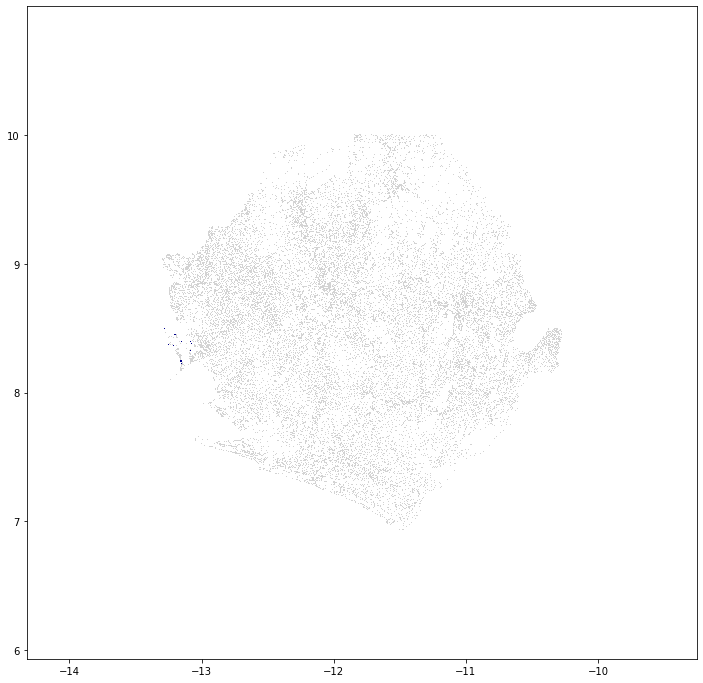

<Figure size 2160x2160 with 0 Axes>

In [21]:
from matplotlib import pyplot as plt
colors = ['#D3D3D3','#808080']
plt.figure(figsize=(12,12))
plt.plot(onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==0, SET_X_DEG], onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==0, SET_Y_DEG], color='#D3D3D3', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==1, SET_X_DEG], onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==1, SET_Y_DEG], color='#00008B', marker=',', linestyle='none')
if onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min() > onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min():
    plt.xlim(onsseter.df[SET_X_DEG].min() - 1, onsseter.df[SET_X_DEG].max() + 1)
    plt.ylim((onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 - 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) - 1, (onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 + 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) + 1)
else:
    plt.xlim((onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 - 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) - 1, (onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 + 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) + 1)
    plt.ylim(onsseter.df[SET_Y_DEG].min() -1, onsseter.df[SET_Y_DEG].max() +1)
plt.figure(figsize=(30,30))
logging.getLogger('matplotlib.font_manager').disabled = True

In some cases it can be of interest to filter out clusters with very low populations, e.g. to increase computational speed or to remove false positives in the data. Setting the **pop_threshold** variable below larger than 0 will filter out all settlements below that threshold form the analysis.

In [22]:
pop_threshold = 0  # If you wish to remove low density population cells, enter a threshold above 0
onsseter.df = onsseter.df.loc[onsseter.df[SET_POP] > pop_threshold]

# 6. Define the demand

This piece of code defines the target electricity demand in the region/country. Residential electricity demand is defined as kWh/household/year, while all other demands are defined as kWh/capita/year. Note that at the moment, all productive uses demands are set to 0 by default.

**Residential**

In [23]:
# Define the annual household electricity targets to choose from
tier_1 = 38.7  # 38.7 refers to kWh/household/year. 
tier_2 = 219
tier_3 = 803
tier_4 = 2117
tier_5 = 2993

onsseter.prepare_wtf_tier_columns(num_people_per_hh_rural, num_people_per_hh_urban, tier_1, tier_2, tier_3, tier_4, tier_5)

**Non-Residential**

**Note** That social and productive demand should be defined in the preparation step

In [24]:
productive_demand = 1                     # 1 if productive demand is defined and should be included, else 0

# 7. Start a scenario run, which calculate and compare technology costs for every settlement in the country

Based on the previous calculation this piece of code identifies the LCoE that every off-grid technology can provide, for each single populated settlement of the selected country. The cell then takes all the currently grid-connected points in the country, and looks at the points within a certain distance from them, to see if it is more economical to connect them to the grid, or to use one of the off-grid technologies calculated above. Once more points are connected to the grid, the process is repeated, so that new points close to those points might also be connected. This is repeated until there are no new points to connect to the grid.

In [25]:
# You may select to calculate investment cost breakdown (set as 1) or only total investment (set as 2). The latter is faster
cost_choice = 2                ## Option 1 is not available in this version of the code; pls let the value be 2

In [26]:
onsseter.current_mv_line_dist()

try:
    onsseter.df.reset_index(inplace=True)
except ValueError:
    pass

Technology.set_default_values(base_year=start_year, start_year=start_year, end_year=end_year, discount_rate=discount_rate,
                             hv_line_type=hv_line_capacity, hv_line_cost=hv_line_cost, mv_line_type=mv_line_capacity,
                             mv_line_amperage_limit=MV_line_amperage_limit, mv_line_cost=mv_line_cost, lv_line_type=lv_line_capacity,
                             lv_line_cost=lv_line_cost, lv_line_max_length=lv_line_max_length, 
                             service_transf_type=service_Transf_type, service_transf_cost = service_Transf_cost,
                             max_nodes_per_serv_trans=max_nodes_per_serv_trans, mv_lv_sub_station_cost=mv_lv_transformer_cost,
                             mv_mv_sub_station_cost=mv_mv_transformer_cost, hv_lv_sub_station_cost=hv_lv_transformer_cost,
                             hv_mv_sub_station_cost=hv_mv_transformer_cost)

for year in yearsofanalysis:
        
    eleclimit = eleclimits[year]
    time_step = time_steps[year]
    
    
    if year == end_year:
        grid_connect_limit = time_step * annual_new_grid_connections_limit_end * 1000
        grid_cap_gen_limit = time_step * annual_grid_cap_gen_limit_end * 1000
    else:
        grid_connect_limit = time_step * annual_new_grid_connections_limit_intermediate * 1000
        grid_cap_gen_limit = time_step * annual_grid_cap_gen_limit_intermediate * 1000
        
    onsseter.set_scenario_variables(year, num_people_per_hh_rural, num_people_per_hh_urban, time_step,
                                            start_year, urban_target_tier, 
                                            rural_target_tier, productive_demand)

    
    onsseter.diesel_cost_columns(sa_diesel_cost, mg_diesel_cost, year)
    
    
    mg_pv_hybrid_investment, mg_pv_hybrid_capacity = onsseter.calculate_pv_hybrids_lcoe(year, 
                                                                                        year - time_step, 
                                                                                        end_year, 
                                                                                        time_step, 
                                                                                        mg_pv_hybrid_calc,
                                                                                        1, 
                                                                                        pv_path)

    mg_wind_hybrid_investment, mg_wind_hybrid_capacity = onsseter.calculate_wind_hybrids_lcoe(year,
                                                                                              year - time_step,
                                                                                              end_year,
                                                                                              time_step,
                                                                                              mg_wind_hybrid_calc,
                                                                                              wind_path)

    sa_diesel_investment, sa_pv_investment, mg_diesel_investment, \
    mg_wind_investment, mg_hydro_investment, mg_pv_investment = onsseter.calculate_off_grid_lcoes(mg_hydro_calc, 
                                                                                                  mg_wind_calc, 
                                                                                                  mg_pv_calc, 
                                                                                                  sa_pv_calc, 
                                                                                                  mg_diesel_calc,
                                                                                                  sa_diesel_calc, 
                                                                                                  year, 
                                                                                                  end_year, 
                                                                                                  time_step,
                                                                                                  diesel_techs)

    grid_investment, grid_cap_gen_limit, grid_connect_limit = onsseter.pre_electrification(grid_generation_cost, 
                                                                                           year, 
                                                                                           time_step, 
                                                                                           end_year, 
                                                                                           grid_calc, 
                                                                                           grid_cap_gen_limit,
                                                                                           grid_connect_limit)

    onsseter.df[SET_LCOE_GRID + "{}".format(year)], onsseter.df[SET_MIN_GRID_DIST + "{}".format(year)], \
    onsseter.df[SET_ELEC_ORDER + "{}".format(year)], onsseter.df[SET_MV_CONNECT_DIST], grid_investment = \
    onsseter.elec_extension(grid_calc,
                            mv_line_max_length,
                            year,
                            start_year,
                            end_year,
                            time_step,
                            grid_cap_gen_limit,
                            grid_connect_limit,
                            auto_intensification=auto_intensification,
                            prioritization=5,
                            new_investment=grid_investment,
                            threshold=9999999999)

    onsseter.results_columns(year, time_step, 5, auto_intensification)

    onsseter.calculate_investments(sa_diesel_investment, sa_pv_investment, mg_diesel_investment,
                                   mg_pv_investment, mg_wind_investment, mg_hydro_investment, 
                                   mg_pv_hybrid_investment, mg_wind_hybrid_investment, grid_investment, year)

    onsseter.apply_limitations(eleclimit, year, time_step, 5, auto_intensification)

    onsseter.calculate_new_capacity(mg_pv_hybrid_capacity, mg_wind_hybrid_capacity, mg_hydro_calc, mg_wind_calc,
                                            mg_pv_calc, sa_pv_calc, mg_diesel_calc, sa_diesel_calc, grid_calc, year)
    
    onsseter.tech_code_update_jn(year, time_step)

    #onsseter.calc_summaries(df_summary, sumtechs, year)

The electrification rate achieved in 2025 is 75.0 %
The electrification rate achieved in 2030 is 100.0 %


# 8. Results, Summaries and Visualization
With all the calculations and grid-extensions complete, this block gets the final results on which technology was chosen for each point, how much capacity needs to be installed and what it will cost. Then the summaries, plots and maps are generated.

In [27]:
elements = []
for year in yearsofanalysis:
    elements.append("Population{}".format(year))
    elements.append("NewConnections{}".format(year))
    elements.append("Capacity{}".format(year))
    elements.append("Investment{}".format(year))

techs = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "99"]

sumtechs = []
for year in yearsofanalysis:
    sumtechs.extend(["Population{}".format(year) + t for t in techs])
    sumtechs.extend(["NewConnections{}".format(year) + t for t in techs])
    sumtechs.extend(["Capacity{}".format(year) + t for t in techs])
    sumtechs.extend(["Investment{}".format(year) + t for t in techs])
    
if cost_choice == 1:
    for year in yearsofanalysis:
        sumtechs.extend(["InvestmentCostLV{}".format(year) + t for t in techs])
        sumtechs.extend(["InvestmentCostMV{}".format(year) + t for t in techs])
        sumtechs.extend(["InvestmentCostHV{}".format(year) + t for t in techs])
        sumtechs.extend(["InvestmentCostTransformer{}".format(year) + t for t in techs])
        sumtechs.extend(["InvestmentCostConnection{}".format(year) + t for t in techs])
        sumtechs.extend(["CapitalCapacityInvestment{}".format(year) + t for t in techs])
        sumtechs.extend(["RecurringCosts{}".format(year) + t for t in techs])
    else:
        pass

summary = pd.Series(index=sumtechs, name='country')

if cost_choice == 1:
    for year in yearsofanalysis:
        for t in techs:
            summary.loc["Population{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_POP + '{}'.format(year)].sum()
            summary.loc["NewConnections{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_NEW_CONNECTIONS + '{}'.format(year)].sum()
            summary.loc["Capacity{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_NEW_CAPACITY + '{}'.format(year)].sum()/1000
            summary.loc["Investment{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_INVESTMENT_COST + '{}'.format(year)].sum()
            summary.loc["InvestmentCostLV{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), "InvestmentCostLV" + '{}'.format(year)].sum()
            summary.loc["InvestmentCostMV{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), "InvestmentCostMV" + '{}'.format(year)].sum()
            summary.loc["InvestmentCostHV{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), "InvestmentCostHV" + '{}'.format(year)].sum()
            summary.loc["InvestmentCostTransformer{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), "InvestmentCostTransformer" + '{}'.format(year)].sum()
            summary.loc["InvestmentCostConnection{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), "InvestmentCostConnection" + '{}'.format(year)].sum()
            summary.loc["CapitalCapacityInvestment{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), "CapitalCapacityInvestment" + '{}'.format(year)].sum()
            summary.loc["RecurringCosts{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), "RecurringCosts" + '{}'.format(year)].sum()
else:
    for year in yearsofanalysis:
        for t in techs:
            summary.loc["Population{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] == int(t)), SET_POP + '{}'.format(year)].sum()
            summary.loc["NewConnections{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] == int(t)), SET_NEW_CONNECTIONS + '{}'.format(year)].sum()
            summary.loc["Capacity{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] == int(t)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_NEW_CAPACITY + '{}'.format(year)].sum()/1000
            summary.loc["Investment{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] == int(t)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_INVESTMENT_COST + '{}'.format(year)].sum()
    
summary = summary.fillna(0)
     
index = techs + ['Total']
columns = []

if cost_choice == 1:
    for year in yearsofanalysis:
        columns.append("Population{}".format(year))
        columns.append("NewConnections{}".format(year))
        columns.append("Capacity{} (MW)".format(year))
        columns.append("Investment{} (million USD)".format(year))
        columns.append("InvestmentLV{} (million USD)".format(year))
        columns.append("InvestmentMV{} (million USD)".format(year))
        columns.append("InvestmentHV{} (million USD)".format(year))
        columns.append("InvestmentTrans{} (million USD)".format(year))
        columns.append("InvestmentCon{} (million USD)".format(year))
        columns.append("InvestmentCap{} (million USD)".format(year))
        columns.append("RecurringCosts{} (million USD)".format(year))
else:
    for year in yearsofanalysis:
        columns.append("Population{}".format(year))
        columns.append("NewConnections{}".format(year))
        columns.append("Capacity{} (MW)".format(year))
        columns.append("Investment{} (million USD)".format(year))
    
summary_table = pd.DataFrame(index=index, columns=columns)

if cost_choice == 1:
    summary_table[columns[0]] = summary.iloc[0:7].astype(int).tolist() + [int(summary.iloc[0:7].sum())]
    summary_table[columns[1]] = summary.iloc[7:14].astype(int).tolist() + [int(summary.iloc[7:14].sum())]
    summary_table[columns[2]] = summary.iloc[14:21].astype(int).tolist() + [int(summary.iloc[14:21].sum())]
    summary_table[columns[3]] = [round(x/1e4)/1e2 for x in summary.iloc[21:28].astype(float).tolist()] + [round(summary.iloc[21:28].sum()/1e4)/1e2]
    summary_table[columns[4]] = [round(x/1e4)/1e2 for x in summary.iloc[56:63].astype(float).tolist()] + [round(summary.iloc[56:63].sum()/1e4)/1e2]
    summary_table[columns[5]] = [round(x/1e4)/1e2 for x in summary.iloc[63:70].astype(float).tolist()] + [round(summary.iloc[63:70].sum()/1e4)/1e2]
    summary_table[columns[6]] = [round(x/1e4)/1e2 for x in summary.iloc[70:77].astype(float).tolist()] + [round(summary.iloc[70:77].sum()/1e4)/1e2]
    summary_table[columns[7]] = [round(x/1e4)/1e2 for x in summary.iloc[77:84].astype(float).tolist()] + [round(summary.iloc[77:84].sum()/1e4)/1e2]
    summary_table[columns[8]] = [round(x/1e4)/1e2 for x in summary.iloc[84:91].astype(float).tolist()] + [round(summary.iloc[84:91].sum()/1e4)/1e2]
    summary_table[columns[9]] = [round(x/1e4)/1e2 for x in summary.iloc[91:98].astype(float).tolist()] + [round(summary.iloc[91:98].sum()/1e4)/1e2]
    summary_table[columns[10]] = [round(x/1e4)/1e2 for x in summary.iloc[98:105].astype(float).tolist()] + [round(summary.iloc[98:105].sum()/1e4)/1e2]
    
    summary_table[columns[11]] = summary.iloc[28:35].astype(int).tolist() + [int(summary.iloc[28:35].sum())]
    summary_table[columns[12]] = summary.iloc[35:42].astype(int).tolist() + [int(summary.iloc[35:42].sum())]
    summary_table[columns[13]] = summary.iloc[42:49].astype(int).tolist() + [int(summary.iloc[42:49].sum())]
    summary_table[columns[14]] = [round(x/1e4)/1e2 for x in summary.iloc[49:56].astype(float).tolist()] + [round(summary.iloc[49:56].sum()/1e4)/1e2]
    summary_table[columns[15]] = [round(x/1e4)/1e2 for x in summary.iloc[105:112].astype(float).tolist()] + [round(summary.iloc[105:112].sum()/1e4)/1e2]
    summary_table[columns[16]] = [round(x/1e4)/1e2 for x in summary.iloc[112:119].astype(float).tolist()] + [round(summary.iloc[112:119].sum()/1e4)/1e2]
    summary_table[columns[17]] = [round(x/1e4)/1e2 for x in summary.iloc[119:126].astype(float).tolist()] + [round(summary.iloc[119:126].sum()/1e4)/1e2]
    summary_table[columns[18]] = [round(x/1e4)/1e2 for x in summary.iloc[126:133].astype(float).tolist()] + [round(summary.iloc[126:133].sum()/1e4)/1e2]
    summary_table[columns[19]] = [round(x/1e4)/1e2 for x in summary.iloc[133:140].astype(float).tolist()] + [round(summary.iloc[133:140].sum()/1e4)/1e2]
    summary_table[columns[20]] = [round(x/1e4)/1e2 for x in summary.iloc[140:147].astype(float).tolist()] + [round(summary.iloc[140:147].sum()/1e4)/1e2]
    summary_table[columns[21]] = [round(x/1e4)/1e2 for x in summary.iloc[147:154].astype(float).tolist()] + [round(summary.iloc[147:154].sum()/1e4)/1e2]
else:
    summary_table[columns[0]] = summary.iloc[0:11].astype(int).tolist() + [int(summary.iloc[0:11].sum())]
    summary_table[columns[1]] = summary.iloc[11:22].astype(int).tolist() + [int(summary.iloc[11:22].sum())]
    summary_table[columns[2]] = summary.iloc[22:33].astype(int).tolist() + [int(summary.iloc[22:33].sum())]
    summary_table[columns[3]] = [round(x/1e4)/1e2 for x in summary.iloc[33:44].astype(float).tolist()] + [round(summary.iloc[33:44].sum()/1e4)/1e2]
    summary_table[columns[4]] = summary.iloc[44:55].astype(int).tolist() + [int(summary.iloc[44:55].sum())]
    summary_table[columns[5]] = summary.iloc[55:66].astype(int).tolist() + [int(summary.iloc[55:66].sum())]
    summary_table[columns[6]] = summary.iloc[66:77].astype(int).tolist() + [int(summary.iloc[66:77].sum())]
    summary_table[columns[7]] = [round(x/1e4)/1e2 for x in summary.iloc[77:88].astype(float).tolist()] + [round(summary.iloc[77:88].sum()/1e4)/1e2]
    
map_dict = {'1': 'Grid_dens', 
            '2': 'SA_Diesel', 
            '3': 'SA_PV', 
            '4': 'MG_Diesel', 
            '5': 'MG_PV', 
            '6': 'MG_Wind', 
            '7': 'MG_Hydro', 
            '8': 'MG_PV_Hybrid', 
            '9': 'MG_Wind_Hybrid', 
            '10':'Grid_ext', 
            '99':'Non-electrified',
            'Total': 'Total'}

summary_table.index = summary_table.index.to_series().map(map_dict)

In [28]:
display(Markdown('### Summary \n These are the summarized results of the selected country'))
summary_table

### Summary 
 These are the summarized results of the selected country

,Population2025,NewConnections2025,Capacity2025 (MW),Investment2025 (million USD),Population2030,NewConnections2030,Capacity2030 (MW),Investment2030 (million USD)
Grid_dens,2572809,745128,98,188.32,3099343,526548,69,131.48
SA_Diesel,0,0,0,0.00,0,0,0,0.00
SA_PV,555114,555114,16,72.71,1140818,593921,18,81.24
MG_Diesel,0,0,0,0.00,0,0,0,0.00
MG_PV,0,0,0,0.00,0,0,0,0.00
MG_Wind,0,0,0,0.00,0,0,0,0.00
MG_Hydro,84815,84815,2,9.26,73765,8914,0,1.66
MG_PV_Hybrid,2422239,2422239,88,251.90,2689646,97601,3,43.70
MG_Wind_Hybrid,0,0,0,0.00,0,0,0,0.00
Grid_ext,923136,923136,15,83.06,2683091,1913811,216,483.19


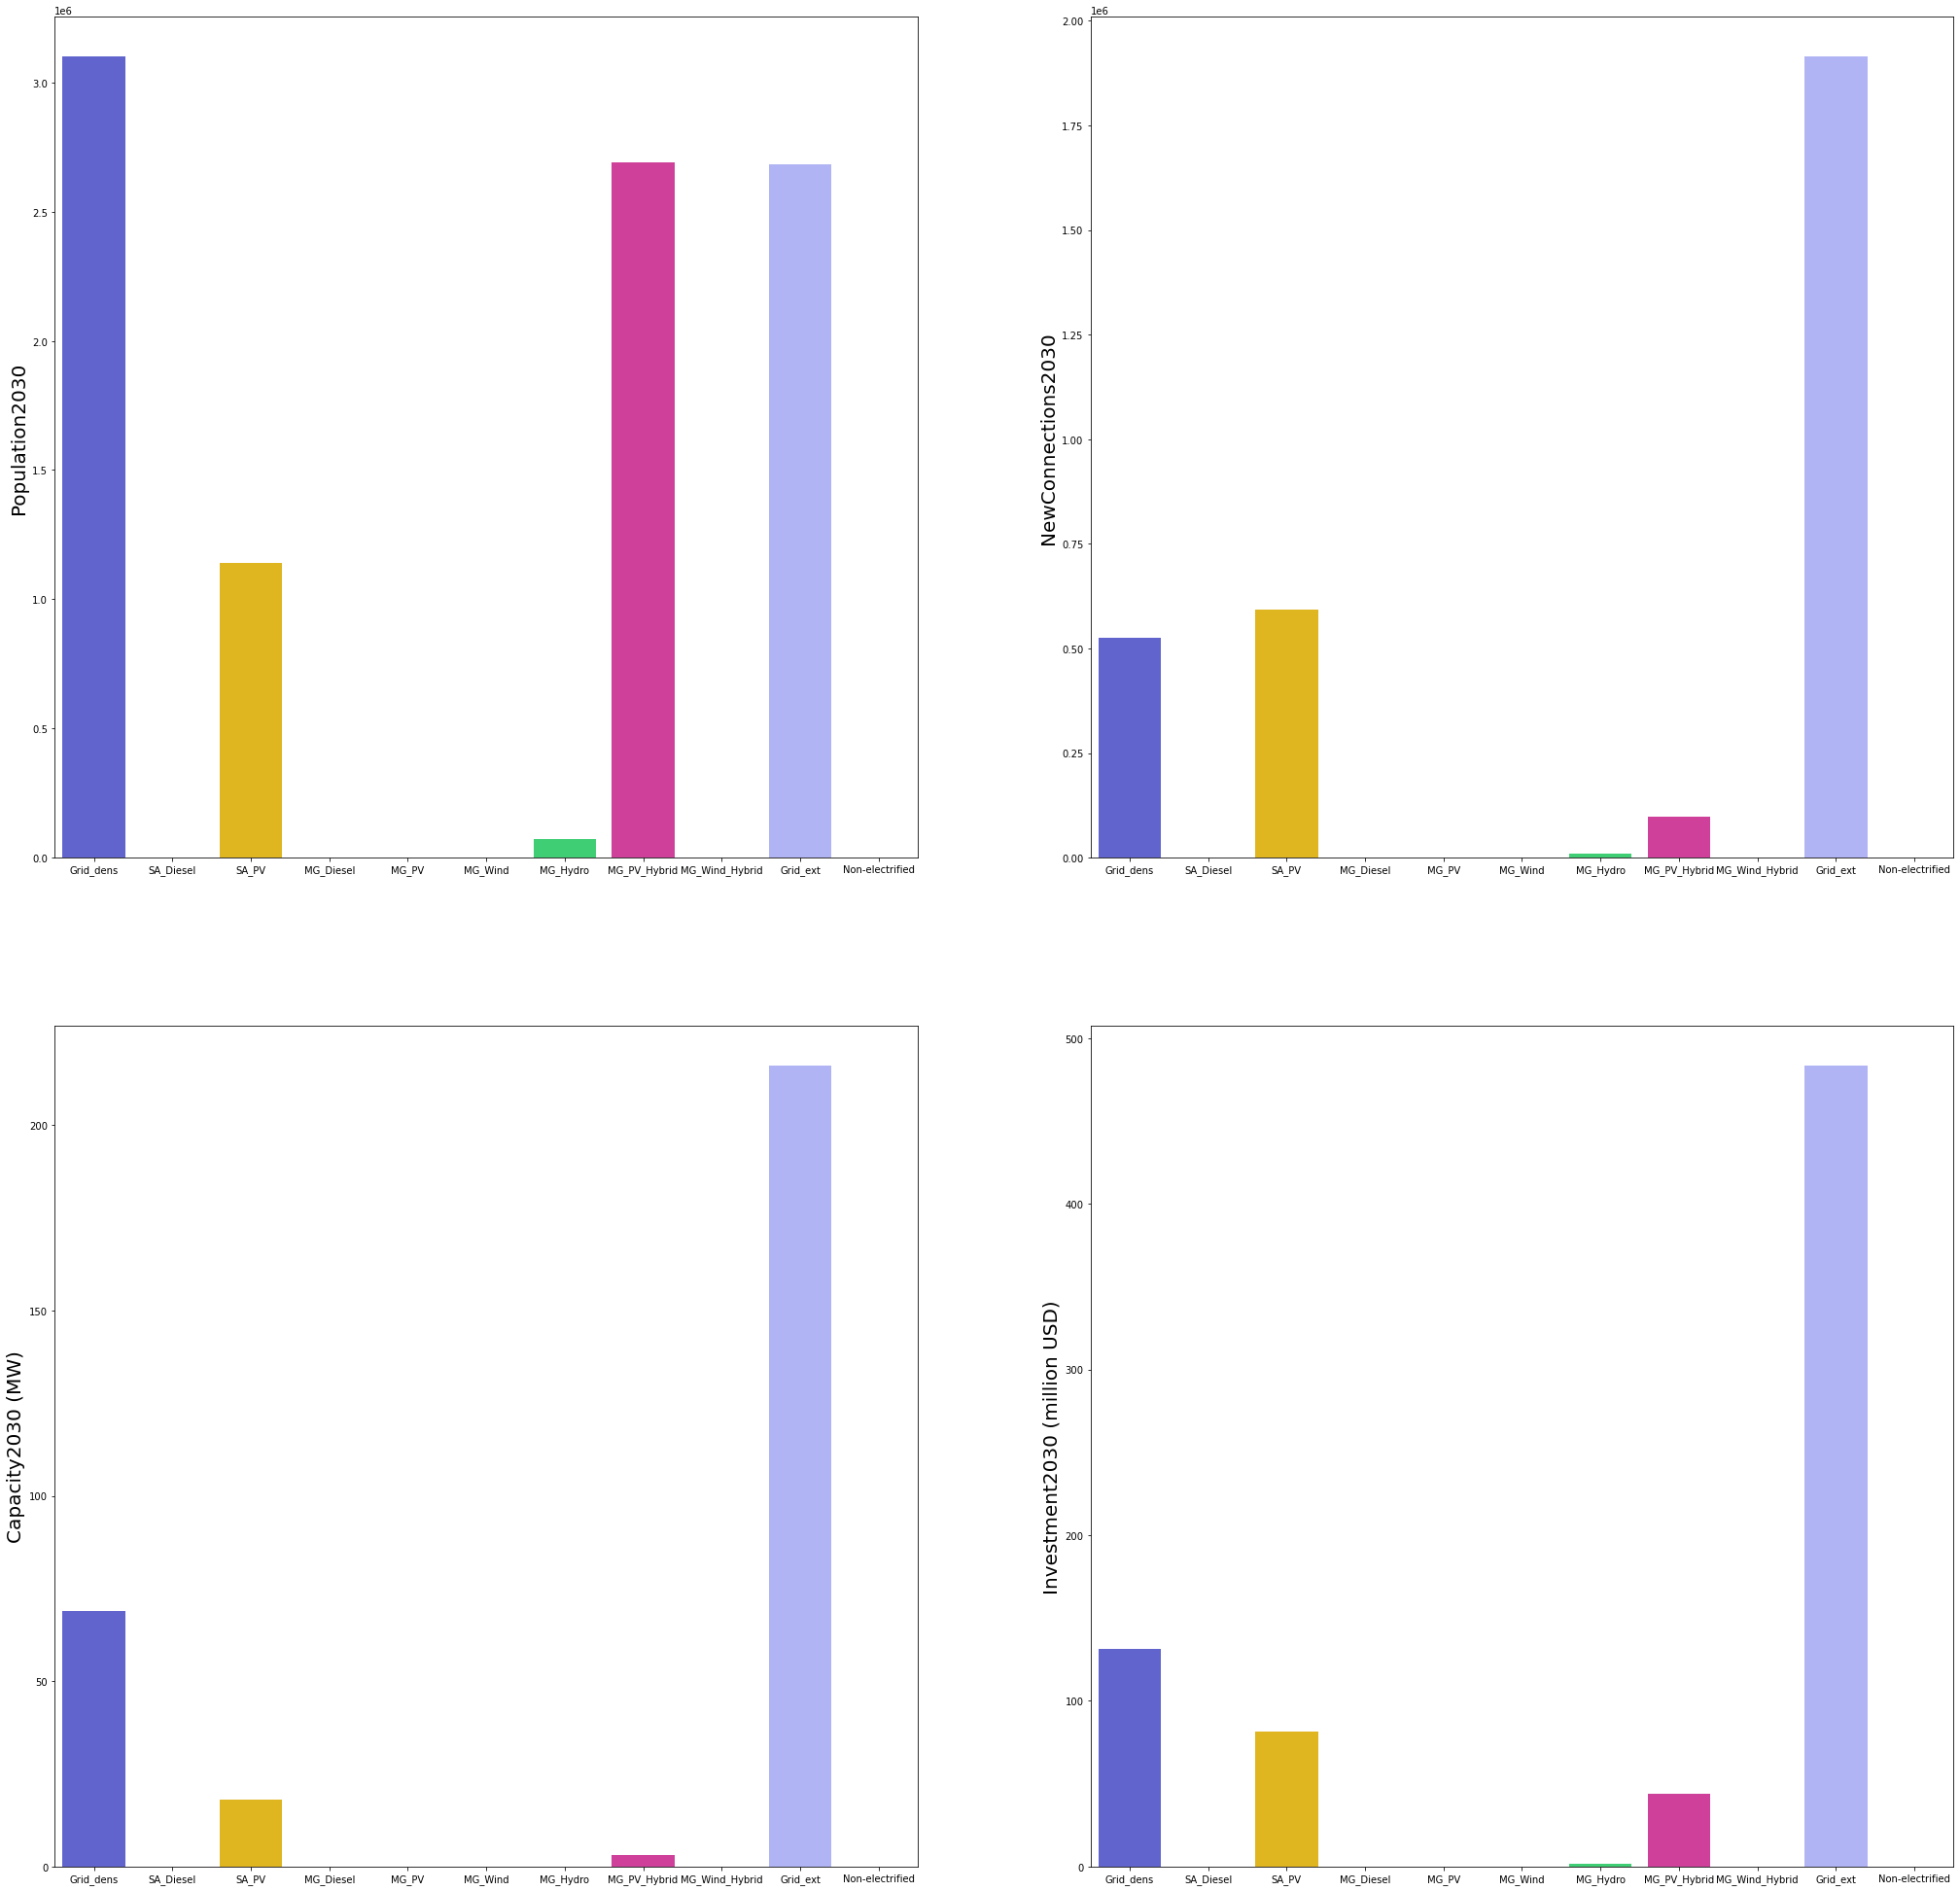

In [29]:
import matplotlib.pylab as plt
import seaborn as sns

colors = ['#4e53de','#EDD100','#ffc700','#1F6600','#98E600','#70A800','#28e66d', '#e628a0', '#1b8f4d', '#a6aaff', '#D3D3D3']
techs_colors = dict(zip(techs, colors))

summary_plot=summary_table.drop(labels='Total',axis=0)
fig_size = [35, 35]
font_size = 1
plt.rcParams["figure.figsize"] = fig_size
f, axarr = plt.subplots(2, 2)
fig_size = [15, 15]
font_size = 10
plt.rcParams["figure.figsize"] = fig_size

if cost_choice == 1:
    sns.barplot(x=summary_plot.index.tolist(), y=columns[11], data=summary_plot, ax=axarr[0, 0], palette=colors)
    axarr[0, 0].set_ylabel(columns[4], fontsize=2*font_size)
    axarr[0, 0].tick_params(labelsize=font_size)
    sns.barplot(x=summary_plot.index.tolist(), y=columns[12], data=summary_plot, ax=axarr[0, 1], palette=colors)
    axarr[0, 1].set_ylabel(columns[5], fontsize=2*font_size)
    axarr[0, 1].tick_params(labelsize=font_size)
    sns.barplot(x=summary_plot.index.tolist(), y=columns[13], data=summary_plot, ax=axarr[1, 0], palette=colors)
    axarr[1, 0].set_ylabel(columns[6], fontsize=2*font_size)
    axarr[1, 0].tick_params(labelsize=font_size)
    sns.barplot(x=summary_plot.index.tolist(), y=columns[14], data=summary_plot, ax=axarr[1, 1], palette=colors)
    axarr[1, 1].set_ylabel(columns[7], fontsize=2*font_size)
    axarr[1, 1].tick_params(labelsize=font_size)
else:
    sns.barplot(x=summary_plot.index.tolist(), y=columns[4], data=summary_plot, ax=axarr[0, 0], palette=colors)
    axarr[0, 0].set_ylabel(columns[4], fontsize=2*font_size)
    axarr[0, 0].tick_params(labelsize=font_size)
    sns.barplot(x=summary_plot.index.tolist(), y=columns[5], data=summary_plot, ax=axarr[0, 1], palette=colors)
    axarr[0, 1].set_ylabel(columns[5], fontsize=2*font_size)
    axarr[0, 1].tick_params(labelsize=font_size)
    sns.barplot(x=summary_plot.index.tolist(), y=columns[6], data=summary_plot, ax=axarr[1, 0], palette=colors)
    axarr[1, 0].set_ylabel(columns[6], fontsize=2*font_size)
    axarr[1, 0].tick_params(labelsize=font_size)
    sns.barplot(x=summary_plot.index.tolist(), y=columns[7], data=summary_plot, ax=axarr[1, 1], palette=colors)
    axarr[1, 1].set_ylabel(columns[7], fontsize=2*font_size)
    axarr[1, 1].tick_params(labelsize=font_size)

<Figure size 720x720 with 0 Axes>

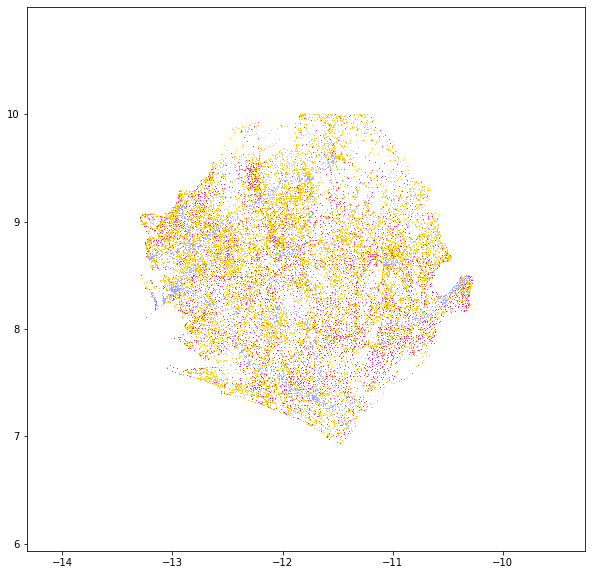

<Figure size 720x720 with 0 Axes>

In [30]:
from matplotlib import pyplot as plt
colors = ['#4e53de','#EDD100','#ffc700','#1F6600','#98E600','#70A800','#28e66d', '#e628a0', '#1b8f4d', '#a6aaff', '#D3D3D3']
plt.figure(figsize=(10,10))
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==3, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==3, SET_Y_DEG], color='#ffc700', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==2, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==2, SET_Y_DEG], color='#a6aaff', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==4, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==4, SET_Y_DEG], color='#1F6600', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==5, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==5, SET_Y_DEG], color='#e628a0', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==6, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==6, SET_Y_DEG], color='#1b8f4d', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==7, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==7, SET_Y_DEG], color='#28e66d', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==8, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==8, SET_Y_DEG], color='#e628a0', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==9, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==9, SET_Y_DEG], color='#1b8f4d', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==1, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==1, SET_Y_DEG], color='#4e53de', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==10, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==10, SET_Y_DEG], color='#a6aaff', marker=',', linestyle='none')
if onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min() > onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min():
    plt.xlim(onsseter.df[SET_X_DEG].min() - 1, onsseter.df[SET_X_DEG].max() + 1)
    plt.ylim((onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 - 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) - 1, (onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 + 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) + 1)
else:
    plt.xlim((onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 - 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) - 1, (onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 + 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) + 1)
    plt.ylim(onsseter.df[SET_Y_DEG].min() -1, onsseter.df[SET_Y_DEG].max() +1)
plt.figure(figsize=(10,10))

## 9. Exporting results

This code generates three csv files:
 - one containing all the results for the scenario created
 - one containing the summary for the scenario created
 - one containing some if the key input variables of the scenario

Before we proceed, please write the scenario_name in the first cell below. then move on to the next cell and run it to browse to the directory where you want to save your results. Sample file shall be located at .\ gep-onsset\sample_output. 

**Note that if you do not change the scenario name, the previous output files will be overwritten

In [31]:
scenario_name = "Sample_Scenario"

In [32]:
list1 = [('Start_year',start_year,'','',''), 
         ('End_year',end_year,'','',''),
         ('End year electrification rate target',electrification_rate_target,'','',''),
         ('Intermediate target year', intermediate_year,'','',''),
         ('Intermediate electrification rate target', intermediate_electrification_target,'','',''),
         ('PV cost adjustment factor', pv_adjustment_factor, '', '', ''),
         ('Urban target tier', urban_target_tier, '', '', ''),
         ('Rural target tier', rural_target_tier, '', '', ''),
         ('Prioritization', prioritization,'','','5 = least cost, 4 = forced grid within buffer only, 6 = forced grid within buffer & least cost out of the buffer zone'),
         ('Auto intensification distance', auto_intensification, '', '', 'Buffer distance (km) for automatic intensification if choosing prioritization 1'),
         ('discount_rate',discount_rate,'','',''),
         ('pop_threshold',pop_threshold,'','',''),
         ('pop_start_year',pop_start_year,'','','the population in the base year (e.g. 2018)'),
         ('pop_end_year',end_year_pop,'','','the projected population in the end year (e.g. 2030)'),
         ('urban_ratio_start_year',urban_ratio_start_year,'','','the urban population population ratio in the base year (e.g. 2018)'),
         ('urban_ratio_end_year',urban_ratio_end_year,'','','the urban population population ratio in the end year (e.g. 2030)'),
         ('num_people_per_hh_urban',num_people_per_hh_urban,'','','the number of people per household expected in the end year (e.g. 2030)'),
         ('num_people_per_hh_rural',num_people_per_hh_rural,'','','the number of people per household expected in the end year (e.g. 2030)'),
         ('elec_ratio_start_year',elec_ratio_start_year,'','','the electrification rate in the base year (e.g. 2018)'),
         ('urban_elec_ratio',urban_elec_ratio,'','','urban electrification rate in the base year (e.g. 2018)'),
         ('rural_elec_ratio',rural_elec_ratio,'','','rural electrification rate in the base year (e.g. 2018)'),
         ('grid_generation_cost',grid_generation_cost,'','','This is the grid cost electricity USD/kWh as expected in the end year of the analysis'),
         ('grid_power_plants_capital_cost',grid_power_plants_capital_cost,'','','The cost in USD/kW to for capacity upgrades of the grid-connected power plants'),
         ('grid_losses',grid_losses,'','','The fraction of electricity lost in transmission and distribution (percentage)'),
         ('base_to_peak',grid_calc.base_to_peak_load_ratio,'','','The ratio of base grid demand to peak demand (percentage)'),
         ('existing_grid_cost_ratio',existing_grid_cost_ratio,'','','The additional cost per round of electrification (percentage)'),
         ('diesel_price',diesel_price,'','','This is the diesel price in USD/liter as expected in the end year of the analysis'),
         ('sa_diesel_capital_cost',sa_diesel_capital_cost,'','','Stand-alone Diesel capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_diesel_capital_cost',mg_diesel_capital_cost,'','','Mini-grid Diesel capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_pv_capital_cost',mg_pv_capital_cost,'','','Mini-grid PV capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_wind_capital_cost',mg_wind_capital_cost,'','','Mini-grid Wind capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_hydro_capital_cost',mg_hydro_capital_cost,'','','Mini-grid Hydro capital cost (USD/kW) as expected in the years of the analysis'),
         ('sa_pv_capital_cost_1',sa_pv_capital_cost_1,'','','Stand-alone PV capital cost (USD/kW) for household systems under 20 W'),
         ('sa_pv_capital_cost_2',sa_pv_capital_cost_2,'','','Stand-alone PV capital cost (USD/kW) for household systems between 21-50 W'),
         ('sa_pv_capital_cost_3',sa_pv_capital_cost_3,'','','Stand-alone PV capital cost (USD/kW) for household systems between 51-100 W'),
         ('sa_pv_capital_cost_4',sa_pv_capital_cost_4,'','','Stand-alone PV capital cost (USD/kW) for household systems between 101-200 W'),
         ('sa_pv_capital_cost_5',sa_pv_capital_cost_5,'','','Stand-alone PV capital cost (USD/kW) for household systems over 200 W'),
         ('mv_line_cost',mv_line_cost,'','','Cost of MV lines in USD/km'),
         ('lv_line_cost',lv_line_cost,'','','Cost of LV lines in USD/km'),
         ('mv_line_capacity',mv_line_capacity,'','','Capacity of MV lines in kW/line'),
         ('lv_line_capacity',lv_line_capacity,'','','Capacity of LV lines in kW/line'),
         ('lv_line_max_length',lv_line_max_length,'','','Maximum length of LV lines (km)'),
         ('hv_line_cost',hv_line_cost,'','','Cost of HV lines in USD/km'),
         ('mv_line_max_length',mv_line_max_length,'','','Maximum length of MV lines (km)'),
         ('hv_lv_transformer_cost',hv_lv_transformer_cost,'','','Cost of HV/MV transformer (USD/unit)'),
         ('mv_increase_rate',mv_increase_rate,'','','percentage'),
         ('max_grid_extension_dist',max_mv_line_dist,'','','Maximum distance that the grid may be extended by means of MV lines'),
         ('annual_new_grid_connections_limit_intermediate', annual_new_grid_connections_limit_intermediate,'','','This is the maximum amount of new households that can be connected to the grid in one year (thousands)'),
         ('annual_new_grid_connections_limit_end', annual_new_grid_connections_limit_end,'','','This is the maximum amount of new households that can be connected to the grid in one year (thousands)'),
         ('grid_capacity_limit_end',annual_grid_cap_gen_limit_end,'','','This is the maximum generation capacity that can be added to the grid in one year (MW)'),
         ('grid_capacity_limit_intermediate',annual_grid_cap_gen_limit_intermediate,'','','This is the maximum generation capacity that can be added to the grid in one year (MW)'),
         ('GIS data: Administrative boundaries','','','','Delineates the boundaries of the analysis.'),
         ('GIS data: DEM','','','','Filled DEM (elevation) maps are use in a number of processes in the analysis (Energy potentials, restriction zones, grid extension suitability map etc.).'),
         ('GIS data: Hydropower','','','','Points showing potential mini/small hydropower potential.  Provides power availability in each identified point.'),
         ('GIS data: Land Cover','','','','Land cover maps are use in a number of processes in the analysis (Energy potentials, restriction zones, grid extension suitability map etc.).'),
         ('GIS data: Night-time Lights','','','','Dataset used to,identify and spatially calibrate the currently electrified/non-electrified population.'),
         ('GIS data: Population','','','','Spatial identification and quantification of the current (base year) population. This dataset sets the basis of the ONSSET analysis as it is directly connected with the electricity demand and the assignment of energy access goals'),
         ('GIS data: Roads','','','','Current road infrastructure is used in order to specify grid extension suitability.'),
         ('GIS data: Solar GHI','','','','Provide information about the Global Horizontal Irradiation (kWh/m2/year) over an area. This is later used to identify the availability/suitability of Photovoltaic systems.'),
         ('GIS data: Substations','','','','Current Substation infrastructure is used in order to specify grid extension suitability.'),
         ('GIS data: Existing grid','','','','Current grid network'),
         ('GIS data: Planned grid','','','','Planned/committed grid network extensions'),
         ('GIS data: Travel-time','','','','Visualizes spatially the travel time required to reach from any individual cell to the closest town with population more than 50,000 people.'),
         ('GIS data: Wind velocity','','','','Provide information about the wind velocity (m/sec) over an area. This is later used to identify the availability/suitability of wind power (using Capacity factors).'),
        ]
labels = ['Variable','Value', 'Source', 'Comments', 'Description']
df_variables = pd.DataFrame.from_records(list1, columns=labels)

In [33]:
messagebox.showinfo('OnSSET', 'Browse to the folder where you want to save the outputs')

output_dir = filedialog.askdirectory()
output_dir_variables = os.path.join(output_dir, '{}_Variables.csv'.format(scenario_name))
output_dir_results = os.path.join(output_dir, '{}_Results.csv'.format(scenario_name))
output_dir_summaries = os.path.join(output_dir, '{}_Summaries.csv'.format(scenario_name))

In [34]:
# Returning the result as a csv file
onsseter.df.to_csv(output_dir_results, index=False)

# Returning the summary as a csv file
summary_table.to_csv(output_dir_summaries, index=True)

# Returning the input variables as a csv file
df_variables.to_csv(output_dir_variables, index=False)